# Homework 7: Classification

## The total score for this assignment will be 100 points, consisting of:
- 10 pt: Overall quality of spelling, grammar, puctuation, etc. of written sentences.
- 10 pt: Codes are written in [PEP 8](https://www.python.org/dev/peps/pep-0008/) style.
- 80 pt: Homework questions. 

This homework assignment is very similar to the in-class lab exercise that you completed this week.


The dataset is from the "Malicious and Benign Websites" Kaggle project at https://www.kaggle.com/xwolf12/malicious-and-benign-websites/home (you'll need to go to that URL to get a full description of the data).

From the overview:

> The project consisted to evaluate different classification models to predict malicious and benign websites, based on application layer and network characteristics. The data were obtained by using different verified sources of benign and malicious URL's, in a low interactive client honeypot to isolate network traffic. We used additional tools to get other information, such as, server country with Whois.

Your task is to build the best classifier you can, choosing from either Random Forests or Naive Bayes classifiers (i.e. no XGBoost, SVM, Logistic Regression, etc.).

You will need to split the complete dataset into training and testing datasets.  We recommend a 70%-30% split.

1. Build both Random Forest (10 points) and Naive Bayes (10 points) classifiers to predict the TYPE variable.  Be sure to provide interpretations of your results.

2. Experiment with changing the number of "folds" in your cross-validator for your Random Forest classifiers (10 points). Be sure to provide interpretations of your results.

3. Tune your Random Forest model by varying hyperparamters (15 points). Be sure to provide interpretations of your results.

3. Experiment with setting the appropriate values for *priors* in the Naive Bayes model (the priors should correspond to the proportions of the TYPE values) (10 points). Be sure to provide interpretations of your results.

4. Report the most important feature(s) based on your Random Forest classifier (10 points). Are you surprised by the results?  Explain why.

5. Summarize your findings, including which classifier and paramters gave you the best results and include an in-depth explanation of how you might improve your results.  You should also investigate what the different fields mean, so you'll need to do some research about websites and internet protocols! (15 points)


In [54]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.ensemble as skens
import sklearn.metrics as skmetric
import sklearn.naive_bayes as sknb
import sklearn.tree as sktree
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)
import sklearn.externals.six as sksix
import IPython.display as ipd
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import os
import warnings
os.environ["PATH"] += os.pathsep + r'C:\Users\tabas\Anaconda3\pkgs\graphviz-2.38-hfd603c8_2\Library\bin\graphviz'
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [26]:
df_websites1 = pd.read_csv('maliciousandbenign.csv')
df_websites1.head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,...,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,...,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,...,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,...,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,...,2,5,4278,61,62,129889,4586,61,4.0,0


In [39]:
df_websites2 = df_websites1.dropna()
df_websites2

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,...,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,...,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,...,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,...,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,...,2,5,4278,61,62,129889,4586,61,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1768,B0_62,160,29,UTF-8,None,36829.0,US,CA,14/08/1997 0:00,14/06/2016 0:00,...,3,7,2402,25,22,4491,2900,25,6.0,0
1769,B0_2237,161,23,iso-8859-1,Apache/2.4.18 (Ubuntu),417.0,None,None,23/11/2010 0:00,20/11/2015 0:00,...,7,2,582,7,11,752,582,7,0.0,0
1774,B0_156,183,29,ISO-8859-1,Microsoft-IIS/7.5; litigation_essentials.lexis...,4890.0,US,NY,26/06/1997 0:00,18/11/2014 0:00,...,2,7,2062,30,26,8161,2742,30,8.0,0
1778,B0_162,201,34,utf-8,Apache/2.2.16 (Debian),8904.0,US,FL,15/02/1999 0:00,15/07/2015 0:00,...,2,6,6631,87,89,132181,6945,87,4.0,0


In [84]:
df_websites = df_websites2[['URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS', 'CONTENT_LENGTH', 'REMOTE_IPS', 'APP_BYTES', 'SOURCE_APP_PACKETS', 'REMOTE_APP_PACKETS', 'SOURCE_APP_BYTES', 'REMOTE_APP_BYTES', 'APP_PACKETS', 'DNS_QUERY_TIMES', 'Type']]
df_websites

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,16,7,263.0,2,700,9,10,1153,832,9,2.0,1
1,16,6,15087.0,4,1230,17,19,1265,1230,17,0.0,0
2,16,6,324.0,0,0,0,0,0,0,0,0.0,0
3,17,6,162.0,3,3812,39,37,18784,4380,39,8.0,0
4,17,6,124140.0,5,4278,61,62,129889,4586,61,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1768,160,29,36829.0,7,2402,25,22,4491,2900,25,6.0,0
1769,161,23,417.0,2,582,7,11,752,582,7,0.0,0
1774,183,29,4890.0,7,2062,30,26,8161,2742,30,8.0,0
1778,201,34,8904.0,6,6631,87,89,132181,6945,87,4.0,0


In [85]:
df_web_train,df_web_test = train_test_split(df_websites, test_size=0.3)

In [86]:
len(df_web_train),len(df_web_test)

(676, 291)

In [87]:
label_train = df_web_train['Type']
label_test = df_web_test['Type']

In [88]:
len(label_train),len(label_test)

(676, 291)

In [89]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf_vec = TfidfVectorizer()

# web_train = tfidf_vec.fit_transform(df_web_train)
# web_test = tfidf_vec.transform(df_web_test)

In [90]:
# build a random forest
rf_web_model = skens.RandomForestClassifier(n_estimators=10,oob_score=True, criterion='entropy')
rf_web_model.fit(df_web_train.iloc[:,:11],label_train)

C:\Users\tabas\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\tabas\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [92]:
predicted_labels = rf_web_model.predict(df_web_test.iloc[:,:11])
df_web_test['predicted_rf_tree'] = predicted_labels

C:\Users\tabas\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [93]:
def comparePlot(input_frame,real_column,predicted_column):
    df_a = input_frame.copy()
    df_b = input_frame.copy()
    df_a['label_source'] = 'Type'
    df_b['label_source'] = 'Classifier'
    df_a['label'] = df_a[real_column]
    df_b['label'] = df_b[predicted_column].apply(lambda x: 'Predict %s'%x)
    df_c = pd.concat((df_a, df_b), axis=0, ignore_index=True)
    sns.lmplot(x='benign', y='malicious', col='label_source',
               hue='label', data=df_c, fit_reg=False, size=4);

In [94]:
comparePlot(df_web_test,"Type","predicted_rf_tree")

C:\Users\tabas\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


KeyError: "['benign', 'malicious'] not in index"

TypeError: 'AxesSubplot' object is not iterable

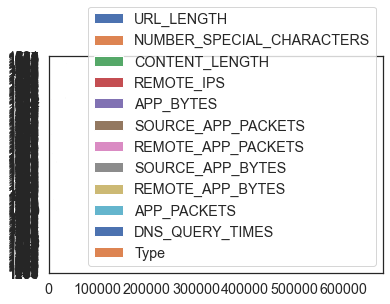

In [95]:
# Check feature importance
web_feat_importance = rf_web_model.feature_importances_
pd.DataFrame({'Feature Importance':web_feat_importance}, index=df_web_train.plot(kind='barh'))

In [ ]:
 X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                            test_size = .3,
                                                            random_state = 42)
    rfc = RandomForestClassifier(n_estimators = 20)
    rfc.fit(X_train, Y_train)
    pred_rfc = rfc.predict(X_test)
    print(classification_report(Y_test, pred_rfc))